# Explore Text Embeddings


Models based off hugging face leaderboard: https://huggingface.co/spaces/mteb/leaderboard

model_names= ["multi-qa-mpnet-base-dot-v1","all-MiniLM-L6-v2", "paraphrase-mpnet-base-v2", "BAAI/bge-small-en-v1.5","BAAI/bge-m3", "bert-base-nli-mean-tokens"]



In [1]:
%%capture
pip install -r ../requirements.txt

In [6]:
import sys 
import numpy as np
import pandas as pd
import time 
# NLP
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Need this set to None otherwise text columns will truncate!
pd.set_option('display.max_colwidth', 100) 

In [7]:
sys.path.append('../scripts/')

In [8]:
from access_data import authenticate_google_drive, grab_google_drive_folder_data

drive = authenticate_google_drive()
text_data = grab_google_drive_folder_data(drive=drive,filename="combined_labeled_data.csv")

Successfully loaded 'combined_labeled_data.csv' into a DataFrame!


In [9]:
def calc_cosine_similarities(dataset, model_list, pos_query, neg_query, column_of_text = 'combine_text'):

    # Initialize output df, which initially is the same as the input one. 
    output_data = dataset.copy()

    # Specify which column should be encoded
    text_to_encode = dataset[column_of_text]

    # Iterate over each model, encode the queries
    for model in model_list:

        print('started with model: ' + model)
        start_time = time.time()
        # Load in the model
        load_model = SentenceTransformer(model, device="cpu") 
    
        pos_embedding = load_model.encode(pos_query)
        neg_embedding = load_model.encode(neg_query)
        
        pos_sim_list = []
        neg_sim_list = []
        
        # Iterate over each post for that model, and calculate each post's cosine sim score to each query's embedding
        for post in text_to_encode:
    
            # Encode the post with chosen model
            embeddings = load_model.encode(post)
            
            # Compute similarity of positive / negative queries to the post:
            pos_sim_score = np.dot(pos_embedding, embeddings) / (np.linalg.norm(pos_embedding) * np.linalg.norm(embeddings))
            neg_sim_score = np.dot(neg_embedding, embeddings) / (np.linalg.norm(neg_embedding) * np.linalg.norm(embeddings))
                
            # Append each post's similarity to the list
            pos_sim_list.append(pos_sim_score)
            neg_sim_list.append(neg_sim_score)
            
    
        # Once done for all posts, save scores to output df, under that model's name
        output_data[model + '_positive'] = pos_sim_list
        output_data[model + '_negative'] = neg_sim_list
    
        # Free memory after each model. Got a runtime error without this. 
        del load_model
        end_time = time.time()
        elapsed_time = end_time - start_time
    
        print("Done with ",  model, f" in {elapsed_time}")

    return output_data
        


## Inputs to function

# Embed the query and compute similarity scores
negative_query = "Terrible experience with this company, never using them again."
positive_query = "I've had a fantastic experience with this company."  

data = text_data.copy()

# Models to try. Based off hugging face leaderboard: https://huggingface.co/spaces/mteb/leaderboard
# model_names = ["multi-qa-mpnet-base-dot-v1", "thenlper/gte-large", "BAAI/bge-m3", "intfloat/multilingual-e5-small"]
model_names= ["multi-qa-mpnet-base-dot-v1","all-MiniLM-L6-v2", "paraphrase-mpnet-base-v2", "BAAI/bge-small-en-v1.5","BAAI/bge-m3", "bert-base-nli-mean-tokens"]

## End Inputs
cosine_dim_data = calc_cosine_similarities(data, model_names, positive_query, negative_query)

started with model: multi-qa-mpnet-base-dot-v1
Done with  multi-qa-mpnet-base-dot-v1  in 53.77501583099365
started with model: all-MiniLM-L6-v2
Done with  all-MiniLM-L6-v2  in 11.183015823364258
started with model: paraphrase-mpnet-base-v2
Done with  paraphrase-mpnet-base-v2  in 43.435291051864624
started with model: BAAI/bge-small-en-v1.5
Done with  BAAI/bge-small-en-v1.5  in 15.164243221282959
started with model: BAAI/bge-m3
Done with  BAAI/bge-m3  in 355.2465980052948
started with model: bert-base-nli-mean-tokens
Done with  bert-base-nli-mean-tokens  in 30.24995708465576


In [10]:
cosine_dim_data.shape

(95, 19)

In [11]:
# Add columns for positive and negative queries 
cosine_dim_data['positive_query'] = positive_query
cosine_dim_data['negative_query'] = negative_query

In [12]:
## Calculate cosine similarity between the positive and negative queries

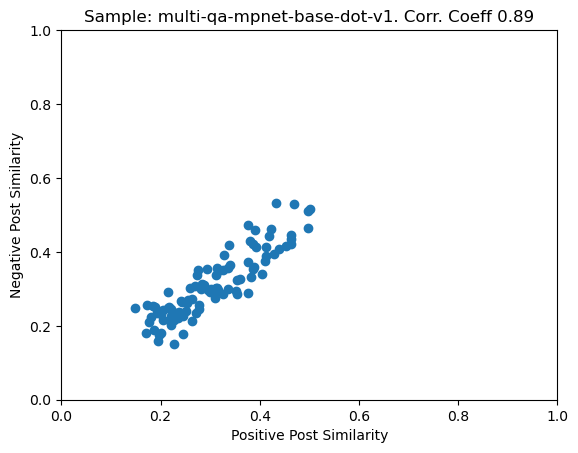

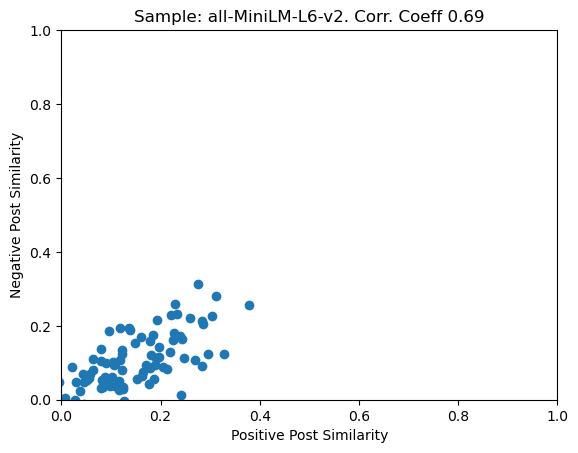

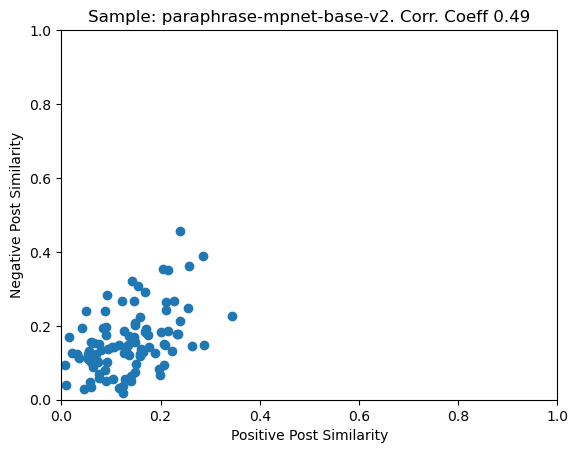

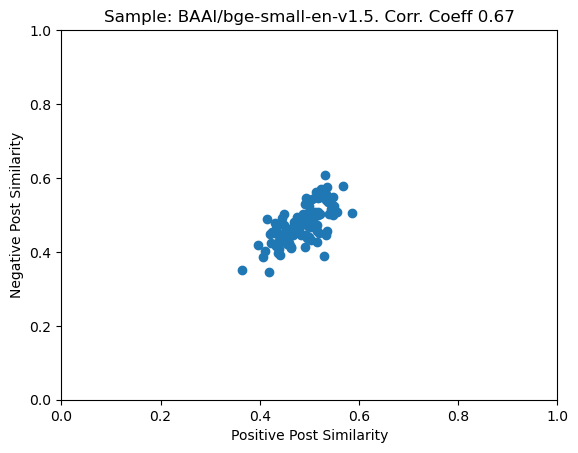

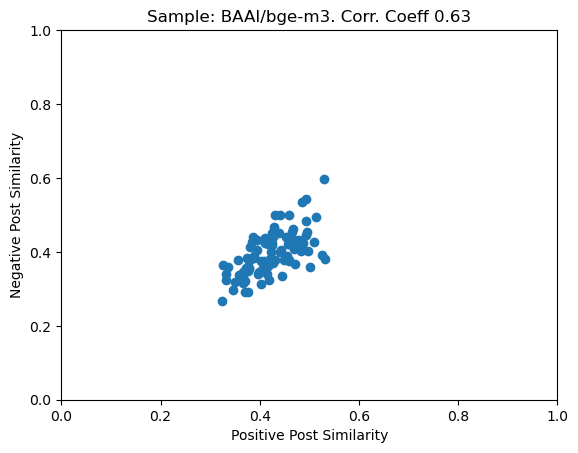

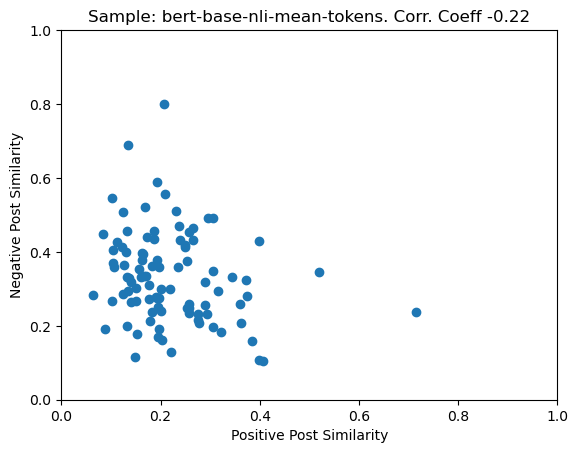

In [13]:
# View scores
import matplotlib.pyplot as plt
for model in model_names:
    plt.scatter(cosine_dim_data[model + '_positive'], cosine_dim_data[model + '_negative'])
    
    correlation_coef = cosine_dim_data[model + '_positive'].corr(cosine_dim_data[model + '_negative'])
    
    plt.title('Sample: ' + model + '. Corr. Coeff ' + str(round(correlation_coef, 2)))

    # Set the x-axis range
    plt.xlim(0, 1)
    plt.xlabel('Positive Post Similarity')

    # y-axis range
    plt.ylim(0, 1)
    plt.ylabel('Negative Post Similarity')
    plt.show()

## Evaluate the embedding models 

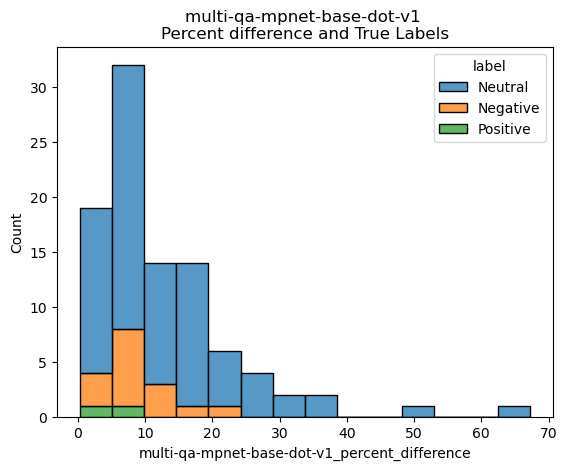

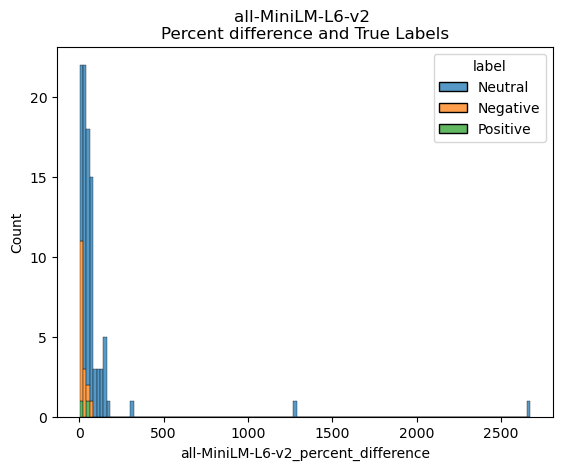

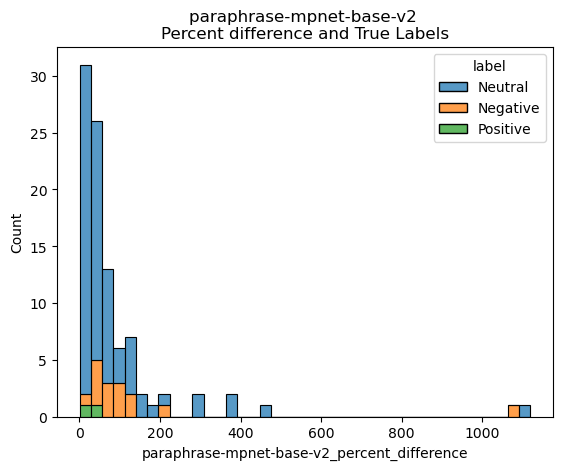

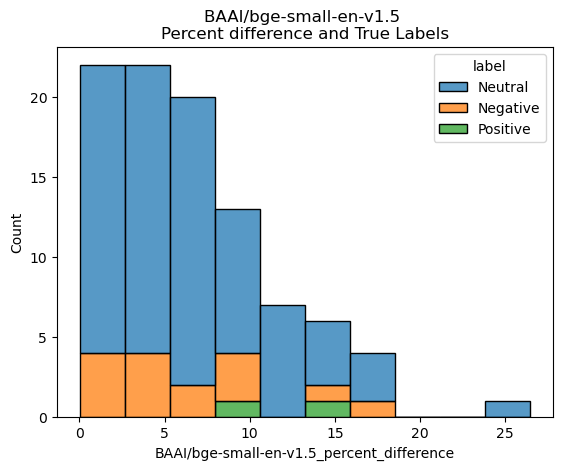

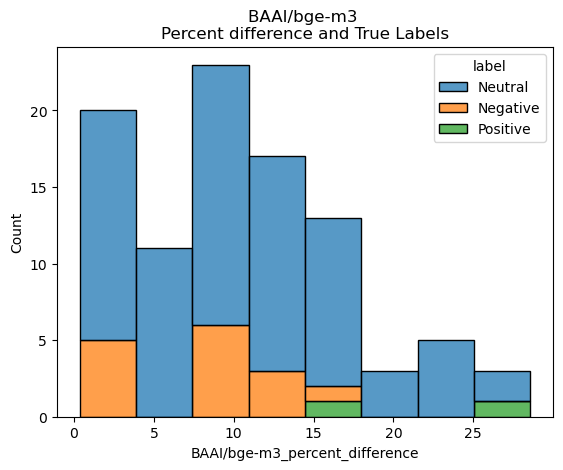

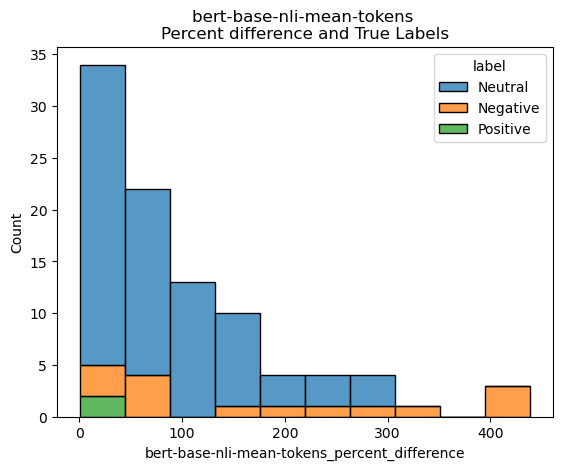

In [14]:
import seaborn as sns 
def calculate_percent_difference(v1, v2): 
    return abs((v2-v1)/abs(v1)) * 100.0

for tv in model_names: 
    cosine_dim_data[f'{tv}_percent_difference'] = cosine_dim_data.apply(lambda x: calculate_percent_difference(x[f"{tv}_positive"], x[f"{tv}_negative"]), axis=1)
    sns.histplot(data=cosine_dim_data, x=f"{tv}_percent_difference",  hue='label', multiple='stack')
    plt.title(f"{tv} \nPercent difference and True Labels")
    plt.show()


In [15]:
# Construct aggregation 
negative_values = {}
positive_values = {}

for model in model_names: 
    negative_values[f"{model}_negative"] = 'mean'
    positive_values[f"{model}_positive"] = 'mean'

In [16]:
# nderstand the relationship between some of these calculated cosine fields and the true label
negative_aggregate = cosine_dim_data.groupby('label').agg(negative_values).reset_index()
positive_aggregate = cosine_dim_data.groupby('label').agg(positive_values).reset_index()

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Standardize within each model 
negative_columns = list(negative_values.keys())
positive_columns = list(positive_values.keys())

for col in negative_columns:
    scaler = MinMaxScaler()
    negative_aggregate[col] = scaler.fit_transform(negative_aggregate[[col]])

for col in positive_columns:
    scaler = MinMaxScaler()
    positive_aggregate[col] = scaler.fit_transform(positive_aggregate[[col]])


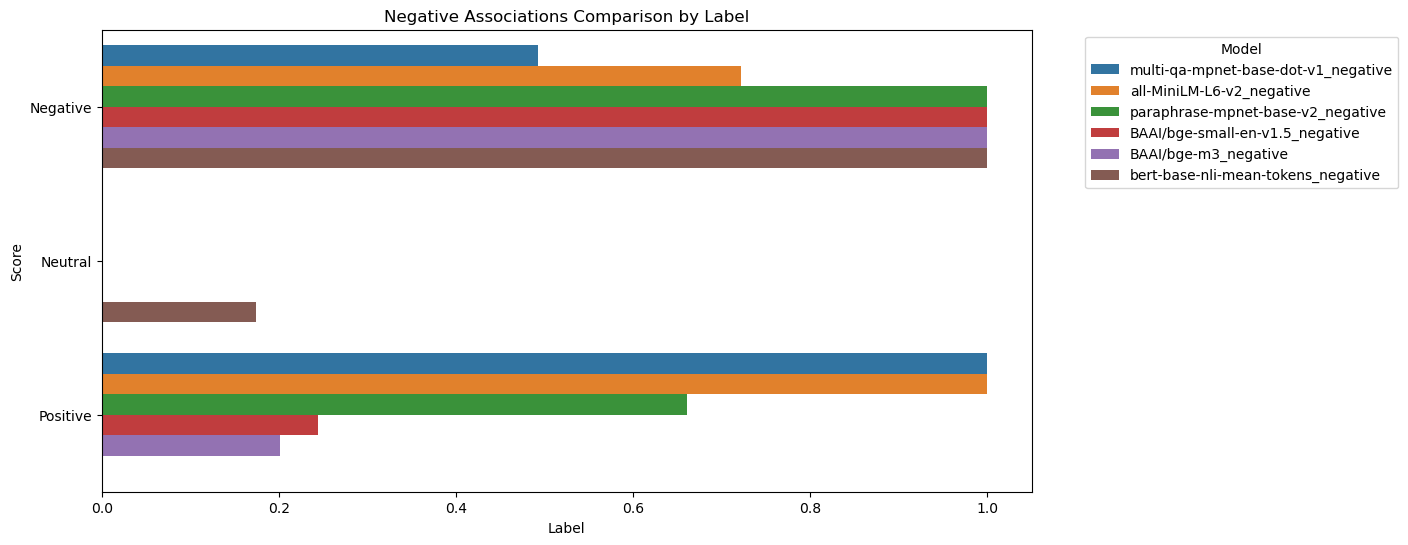

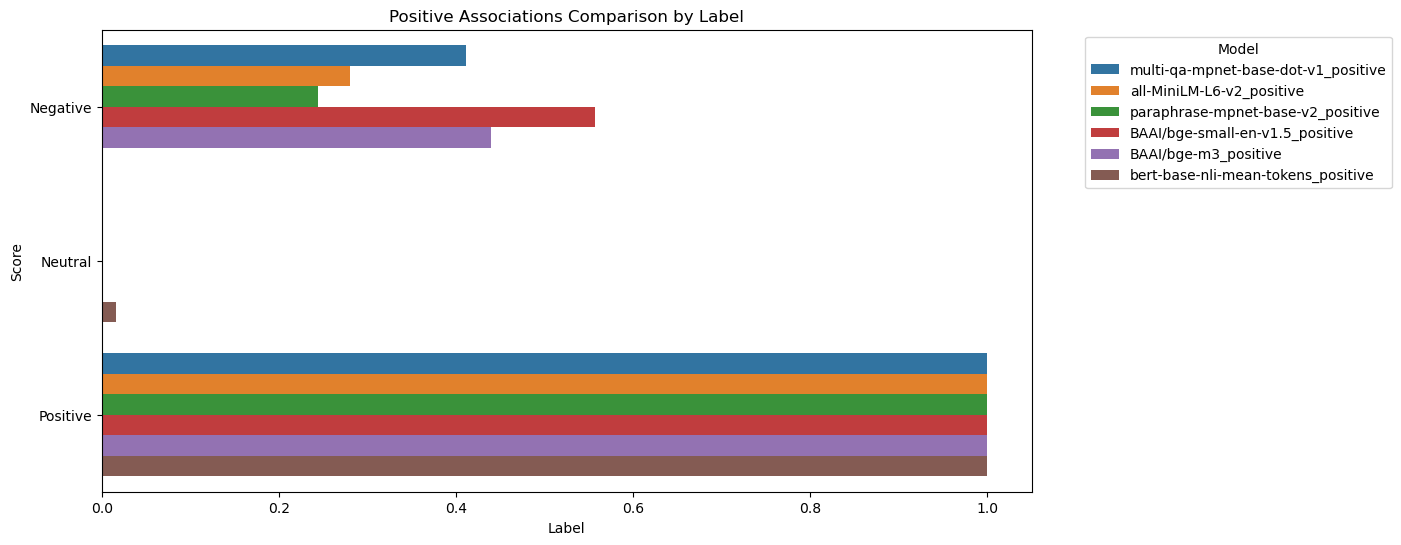

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler


negative_aggregate
df_long = negative_aggregate.melt(id_vars='label', var_name='model', value_name='value')
# df_long
# Negative 
plt.figure(figsize=(12, 6))
sns.barplot(y='label', x='value', hue='model', data=df_long)
plt.title('Negative Associations Comparison by Label')
plt.xlabel('Label')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# # Positive 
df_long = positive_aggregate.melt(id_vars='label', var_name='model', value_name='value')
df_long.head() 

plt.figure(figsize=(12, 6))
sns.barplot(y='label', x='value', hue='model', data=df_long)
plt.title('Positive Associations Comparison by Label')
plt.xlabel('Label')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Findings

The top three models based on our use case are: 
1. bert-base-nli-mean-tokens: for both positive and negative
2. BAAI/bge-m3: for negative  (BAAI/bge-small-en-v1.5 similar but more lightweight)
3. paraphrase-mpnet-base-v2: for purchase 
